In [1]:
from itertools import takewhile

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [2]:
plt.rcParams.update({
    "axes.prop_cycle": plt.cycler("color", ['#000000', '#1b6989', '#e69f00', '#009e73', '#f0e442', '#50b4e9', '#d55e00', '#cc79a7']),
    "figure.figsize": [12.0, 5.0],
    "font.serif": ['Palatino',
                   'Palatino Linotype',
                   'Palatino LT STD',
                   'Book Antiqua',
                   'Georgia',
                   'DejaVu Serif'],
    'font.family': 'serif',
    'figure.facecolor': '#fffff8',
    'axes.facecolor': '#fffff8',
    'figure.constrained_layout.use': True,
    'font.size': 14.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0, 
})

# MCMC Basics

Uncertainty may play an important role in business decisions. 

At the end of the day, our goal is to evaluate some *expectation* in the presence of uncertainty. 

## Inverse CDF sampling

Given a probability density function, $p(x)$, the cumulative density function is given by 

$$
\operatorname{cdf}(x) = \int_0^x p(t)~dt
$$

Note that the value $\operatorname{cdf}(x)$ is "the probability that a value is less than $x$", and is between 0 and 1. 

Text(0.5, 1.0, 'Normal cumulative density function')

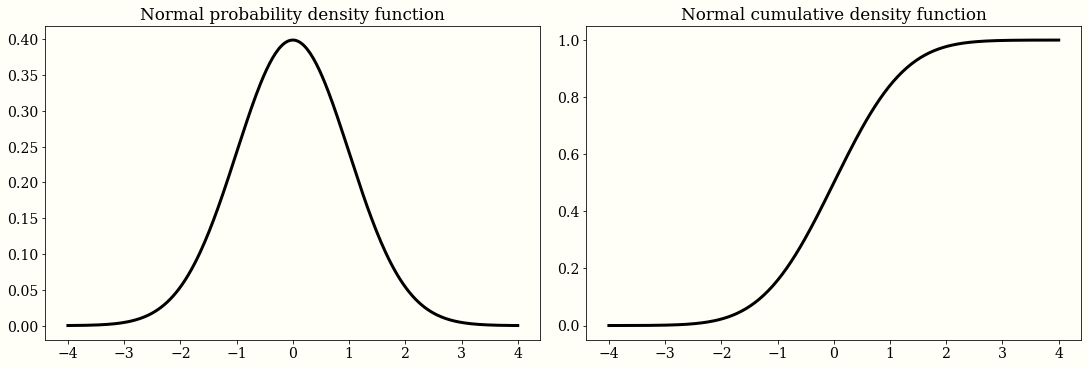

In [3]:
rv = st.norm(0, 1)

t = np.linspace(-4, 4, 300)

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

axes[0].plot(t, rv.pdf(t))
axes[0].set_title('Normal probability density function')
axes[1].plot(t, rv.cdf(t))
axes[1].set_title('Normal cumulative density function')

If we can *invert* the cumulative density function, we have a function $\operatorname{cdf}^{-1}(t)$, where $0 \leq t \leq 1$. We can use this function to draw random values:

1. Draw $u \sim U(0, 1)$
2. Use $y = \operatorname{cdf}^{-1}(u)$ as your sample

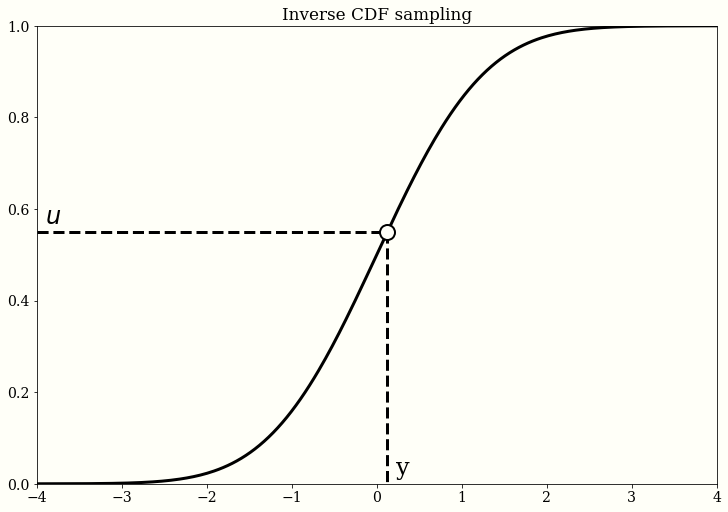

In [4]:
np.random.seed(0)
rv = st.norm(0, 1)

t = np.linspace(-4, 4, 300)
u = np.random.rand()

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(t, rv.cdf(t), color='C0')
ax.text(t.min() + 0.1, u + 0.02, '$u$', fontdict={"fontsize": 24})
ax.hlines(u, t.min(), rv.ppf(u), linestyles='dashed', color='C0')
ax.vlines(rv.ppf(u), u, 0, linestyles='dashed', color='C0')
bg_color = ax.get_facecolor()
ax.plot(rv.ppf(u), u, 'o', mfc=bg_color, ms=15)
ax.text(rv.ppf(u) + 0.1, 0.02, 'y', fontdict={"fontsize": 24})
ax.set_xlim(t.min(), t.max())
ax.set_ylim(0, 1)
ax.set_title('Inverse CDF sampling');

### Inverse CDF exercise: 

Fill out the following function that implements inverse CDF sampling. There is a cell below to visually check your implementation.

In [5]:
def sample(draws, inv_cdf):
    """Draw samples using the inverse CDF of a distribution.
    
    Parameters
    ----------
    draws : int
        Number of draws to return
    inv_cdf : function
        Gives the percentile of the distribution the argument falls in. This is vectorized, like in `scipy.stats.norm.ppf`"""
    # output should be an array of size (draws,), distributed according to inv_cdf
    ####################   
    u = np.random.rand(draws)
    return inv_cdf(u)
    ####################   

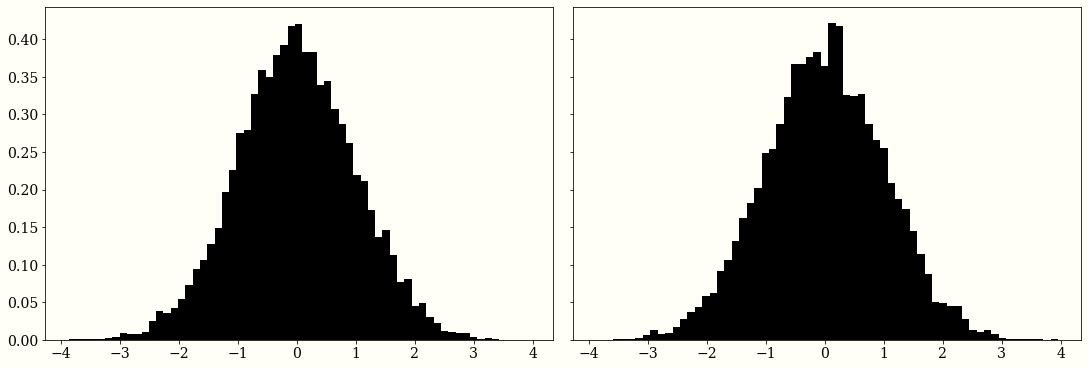

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), sharex=True, sharey=True)
draws = 10_000

# Two histograms should look the same
axes[0].hist(st.norm().rvs(draws), bins='auto', density=True)
axes[1].hist(sample(draws, st.norm().ppf), bins='auto', density=True);

### Inverse CDF exercise (calculus required)

The probability density function of the exponential distribution is 

$$
p(x | \lambda) = \lambda e^{-\lambda x}
$$

Calculate the cumulative density function, invert it, and use the `sample` function above to sample from the exponential function.

Again, there is a plot below to check your implementation.

In [7]:
def inv_cdf_exponential(u, lam=1): 
    # Should return an array of shape `u.shape`
    ####################
    return -np.log(1 - u) / lam
    ####################

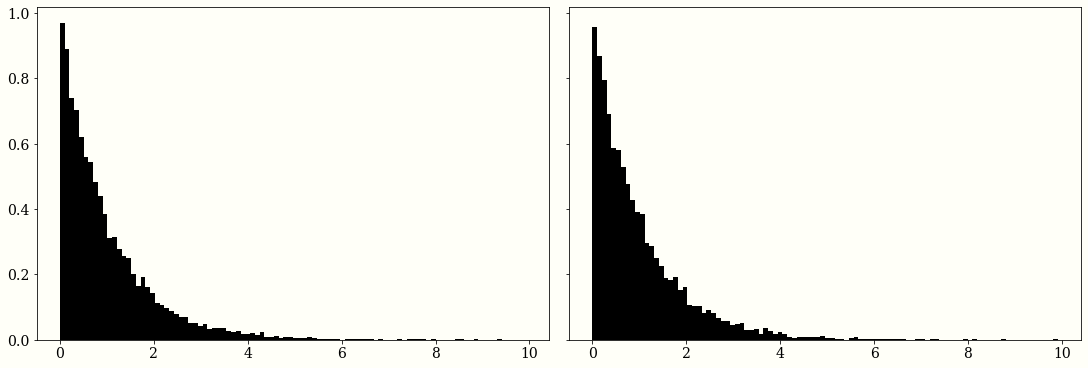

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), sharex=True, sharey=True)
draws = 10_000

# Two histograms should look the same
axes[0].hist(st.expon(scale=1.).rvs(draws), bins='auto', density=True)
axes[1].hist(sample(draws, inv_cdf_exponential), bins='auto', density=True);

### Hints for previous exercise

The cumulative density function is

$$
\operatorname{cdf}(x) = 1-e^{-\lambda x}.
$$

Invert the cumulative density function by solving 
$$
y = 1-e^{-\lambda x}
$$ 

for $x$ in terms of $y$.


## Rejection Sampling

Most integrals are hard or impossible to do. Also, if we are iterating on a statistical model, we may want a method that works without requiring rederiving a formula for generating samples. Further, in Bayesian data analysis, we may not know a *normalizing constant*: we may only know 

$$
\tilde{p}(x) = \frac{1}{Z_p}p(x),
$$

for some constant $Z_p$ ("constant" here is with respect to $x$). In order to sample, first we

1. Choose a proposal distribution $q$ that you know how to sample from
2. Choose a number $k$, so that $kq(x) \geq \tilde{p}(x)$ for all $x$

Then, we repeatedly 

1. Draw a $z$ from $q$
2. Draw a $u$ from $\operatorname{Uniform}(0, kq(z))$
3. If $\tilde{p} > u$, accept the draw, otherwise, reject.

Importantly, every "rejection" is wasted computation! We will explore methods for having less wasted computation later.

In [9]:
def mixture_of_gaussians():
    rvs = (st.norm(-3, 1), st.norm(0, 1), st.norm(3, 1))
    probs = (0.5, 0.2, 0.3)
    def pdf(x):
        return sum(p * rv.pdf(x) for p, rv in zip(probs, rvs))
    return pdf

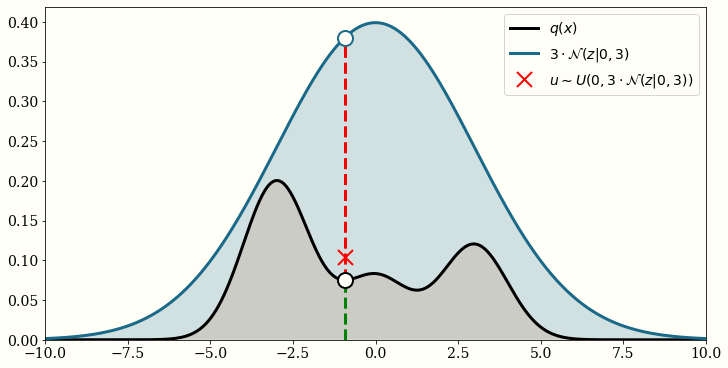

In [10]:
np.random.seed(6)
pdf = mixture_of_gaussians()
q = st.norm(0, 3)
z = q.rvs()
u = np.random.rand() * q.pdf(z)

fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)

t = np.linspace(-10, 10, 500)
ax.plot(t, pdf(t), '-', label='$q(x)$')
ax.fill_between(t, 0, pdf(t), alpha=0.2)
ax.plot(t, 3 * q.pdf(t), '-', label='$3 \cdot \mathcal{N}(z | 0, 3)$')
ax.fill_between(t, pdf(t), 3 * q.pdf(t), alpha=0.2)

bg_color = ax.get_facecolor()
ax.vlines(z, 0, pdf(z), linestyles='dashed', color='green')
ax.vlines(z, pdf(z), 3 * q.pdf(z), linestyles='dashed', color='red')

# ax.plot(z, 0, 'o', label='z', ms=15, mfc=bg_color)
ax.plot(z, pdf(z), 'o', color='C0', ms=15, mfc=bg_color)
ax.plot(z, u, 'rx', label='$u \sim U(0, 3\cdot\mathcal{N}(z | 0, 3))$', ms=15, mfc=bg_color)
ax.plot(z, 3 * q.pdf(z), 'o', color='C1', ms=15, mfc=bg_color)

# ax.plot(z * np.ones(4), np.array([0, pdf(z), u, 3 * q.pdf(z)]), 'ko', ms=15, mfc=bg_color)

ax.set_ylim(bottom=0)
ax.set_xlim(t.min(), t.max())
ax.legend();

### Rejection Sampling Exercise

Sample from the pdf returned by `mixture_of_gaussians` using rejection sampling. We will implement this as a Python generator, and yield the proposed draw, `z`, as well as whether it was accepted. You should assume `proposal_dist` comes from `scipy.stats`, so it has a `.rvs()` method that samples, and a `.pdf` method that evaluates the probability density function at a point.

If $kq(x)$ is not larger than $\tilde{p}(x)$, throw an exception!

The cell below has a plot to check your implementation.

In [11]:
def rejection_sampler(pdf, proposal_dist, k):
    """
    Yields proposals, and whether that proposal should be accepted or rejected
    """
    while True:
        z = proposal_dist.rvs()
        ####################
        prop_pdf = k * proposal_dist.pdf(z)
        if prop_pdf < pdf(z):
            raise RuntimeError(f"Increase k to at least {k * pdf(z) / prop_pdf}!")
        u = np.random.uniform(0, prop_pdf)
        accept = u < pdf(z)
        yield z, accept
        ####################

def gen_samples(draws, sampler):
    """An example of how to use the rejection sampler above."""
    samples = []
    for n_draws, (z, accept) in enumerate(sampler, 1):
        if accept:
            samples.append(z)
            if len(samples) == draws:
                return np.array(samples), n_draws

CPU times: user 43.8 s, sys: 136 ms, total: 43.9 s
Wall time: 43.8 s


Text(0.5, 1.0, '10,000 draws from the pdf with 33.84% efficiency')

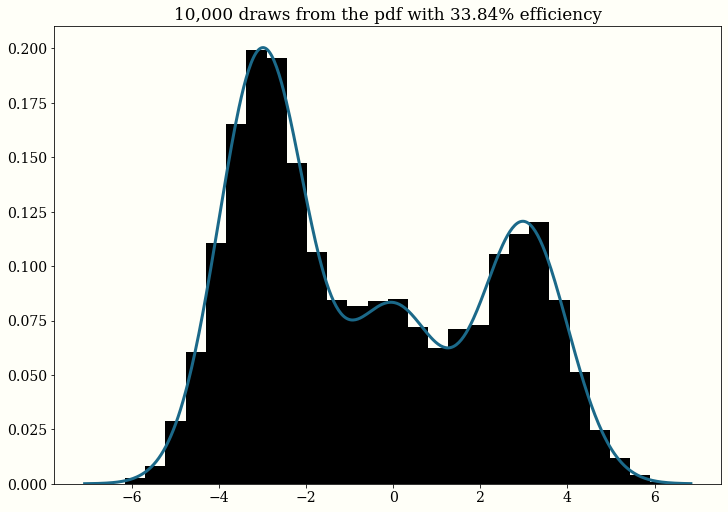

In [12]:
%%time

pdf = mixture_of_gaussians()
proposal_dist = st.norm(0, 3)
k = 3

samples, draws = gen_samples(10_000, rejection_sampler(pdf, proposal_dist, k))

fig, ax = plt.subplots(figsize=(10, 7))

t = np.linspace(samples.min(), samples.max(), 500)

# This histogram should look very similar to the pdf that is plotted
ax.hist(samples, bins='auto', density=True)
ax.plot(t, pdf(t))

ax.set_title(f'{samples.size:,d} draws from the pdf with {100 * samples.size / draws:.2f}% efficiency');

### Exercise: How does a rejection sampler scale with dimension?

Use as your "unknown distribution" a multivariate Gaussian with identity covariance matrix, and use as your proposal distribution a multivariate Gaussian with covariance matrix `1.1 * I`. 

- Around what percent of samples are accepted with dimension 1? 
- 10 dimensions? 
- 100 dimensions? 
- What happens if you try to use 1,000 dimensions?

In [13]:
####################
def run_experiment(dims, trials=1_000_000):
    pdf = st.multivariate_normal(mean=np.zeros(dims), cov=np.eye(dims)).pdf
    prop = st.multivariate_normal(mean=np.zeros(dims), cov=1.1 * np.eye(dims))
    
    k = pdf(0) / prop.pdf(0)

    samples = prop.rvs(trials)
    sample_pdfs = prop.pdf(samples)
    u = np.random.uniform(low=0, high=k * sample_pdfs)
    
    accept = pdf(samples) > u
    return accept.mean()

for dim in (1, 10, 100):
    print(f"{dim}:\t{run_experiment(dim, 10_000_000 // dim)}")
    
# print(run_experiment(dim, 10_000))

# Using 1_000 dimensions underflows, and then overflows. We should use log 
# probabilities to avoid this.
####################

1:	0.9535676
10:	0.621407
100:	0.0083


## Importance sampling is useful but we won't cover it!

It produces _weighted_ samples, so that the output is samples and weights. See 11.1.4 in Bishop's "Pattern Recognition and Machine Learning".

## Introduction to MCMC

One way to intuitively waste less computation is to use knowledge from your current sample to inform your next proposal: this is called a *Markov chain*. Let $t$ be the index of our current sample, $x_t$ be our current sample, and $\operatorname{pdf}(x_t)$ be our probability density function evaluated at the current sample. We will define a *transition probability* that is conditioned on our current position: $T(x_{t + 1} | x_t)$. It turns out that a Markov chain will sample from $\operatorname{pdf}$ if:

- $T$ is ergodic (sort of techinical -- roughly $T$ is aperiodic and can explore the whole space)
- The chain satisfies *detailed balance*, which means $\operatorname{pdf}(x_t)T(x_{t+1} | x_t) = \operatorname{pdf}(x_{t + 1})T(x_{t} | x_{t + 1})$.

This second criteria inspires the *Metropolis acceptance criteria*: If we use any proposal with density function $\operatorname{prop}$, we use this criterion to "correct" the transition probability to satisfy detailed balance:

$$
A(x_{t + 1} | x_t) = \min\left\{1, \frac{\operatorname{pdf}(x_{t + 1})}{\operatorname{pdf}(x_{t})}\frac{\operatorname{prop}(x_{t} | x_{t + 1})}{\operatorname{prop}(x_{t + 1} | x_t)} \right\}
$$

Now the *Metropolis-Hastings Algorithm* is

Initialize at some point $x_0$. For each iteration:

1. Draw $\tilde{x}_{t + 1} \sim \operatorname{prop}(x_t)$
2. Draw $u \sim \operatorname{Uniform}(0, 1)$
3. If $u < A(\tilde{x}_{t + 1} | x_t)$, then $x_{t + 1} = \tilde{x}_{t + 1}$. Otherwise, $x_{t + 1} = x_t$.

This is "tested" in the following cell.

In [14]:
def metropolis_hastings(pdf, proposal, init=0):
    """Yields a sample, and whether it was accepted. Notice that,
    unlike the rejection sampler, even when the second argument is `False`,
    we use the sample! 
    """
    current = init
    while True:
        prop_dist = proposal(current)
        prop = prop_dist.rvs()
        p_accept = min(1, pdf(prop) / pdf(current) * proposal(prop).pdf(current) / prop_dist.pdf(prop))
        accept = np.random.rand() < p_accept
        if accept:
            current = prop
        yield current, accept
        
def gen_samples(draws, sampler):
    """An example of using the metropolis_hastings API."""
    samples = np.empty(draws)
    accepts = 0
    for idx, (z, accept) in takewhile(lambda j: j[0] < draws, enumerate(sampler)):
        accepts += int(accept)
        samples[idx] = z
    return samples, accepts


CPU times: user 41.1 s, sys: 72 ms, total: 41.2 s
Wall time: 41.1 s


Text(0.5, 1.0, '10,000 draws from the pdf with 81.12% accept rate')

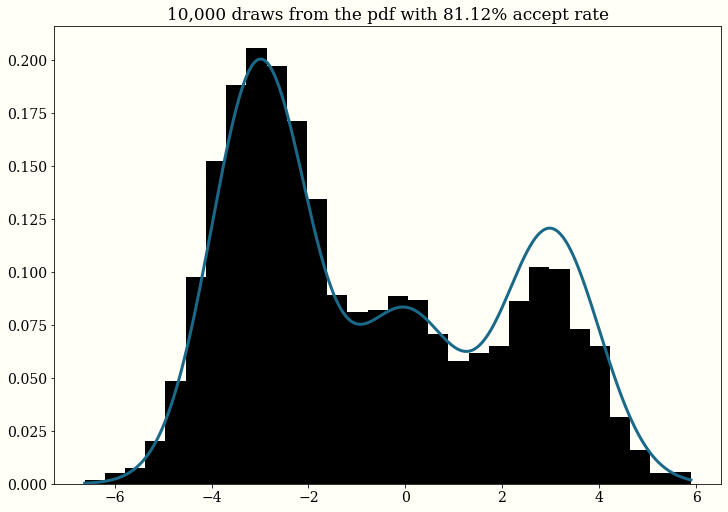

In [15]:
%%time
pdf = mixture_of_gaussians()
proposal_dist = st.norm(0, 3)
k = 3

samples, accepts = gen_samples(10_000, metropolis_hastings(pdf, lambda x: st.norm(x, 1)))

fig, ax = plt.subplots(figsize=(10, 7))

t = np.linspace(samples.min(), samples.max(), 500)
ax.hist(samples, bins='auto', density=True)
ax.plot(t, pdf(t))

ax.set_title(f'{samples.size:,d} draws from the pdf with {100 * accepts / samples.size :.2f}% accept rate');

### MCMC Exercise

This implementation is wildly inefficient! We will speed it up by fixing the proposal distribution as a Gaussian centered at the previous point (this is fairly standard). Specifically,
$$x_{t+1} \sim \mathcal{N}( x_t, \sigma),$$
so
$$\operatorname{prop}(x_{t+1} | x_{t}) = \mathcal{N}(x_{t + 1} | x_t, \sigma)$$

We call $\sigma$ the *step size*.

1. The Metropolis-Hastings acceptance criteria simplifies quite a bit - work out what $A(x_{t + 1} | x_t)$ is now.
2. scipy.stats is doing a lot of work: `st.norm().rvs()` is ~1000x slower than `np.random.randn()`. Rewrite `metropolis_hastings` with the acceptance criteria, and without using `st.norm().rvs()` to provide proposals.

In [16]:
def metropolis_hastings(pdf, step_size, init=0):
    current = init
    while True:
        ####################
        prop = step_size * np.random.randn() + current
        p_accept = min(1, pdf(prop) / pdf(current))
        accept = np.random.rand() < p_accept
        if accept:
            current = prop
        ####################
        yield current, accept

CPU times: user 11.7 s, sys: 68 ms, total: 11.8 s
Wall time: 11.7 s


Text(0.5, 1.0, '10,000 draws from the pdf with 81.50% accept rate')

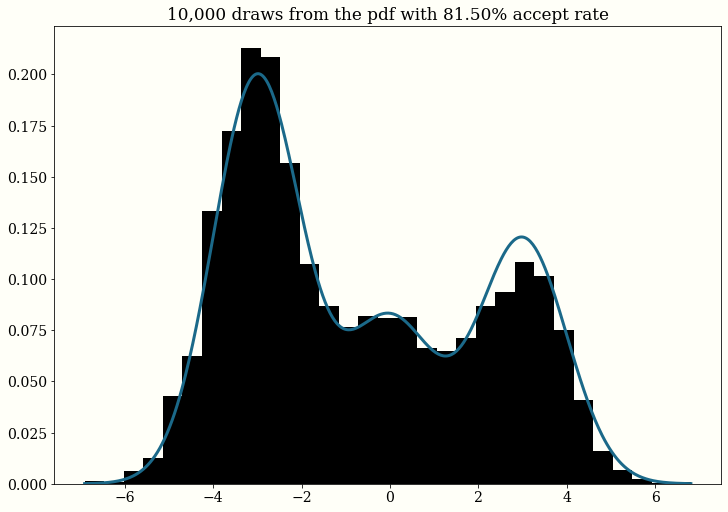

In [17]:
%%time
pdf = mixture_of_gaussians()
proposal_dist = st.norm(0, 3)
k = 3

samples, accepts = gen_samples(10_000, metropolis_hastings(pdf, 1))

fig, ax = plt.subplots(figsize=(10, 7))

t = np.linspace(samples.min(), samples.max(), 500)
ax.hist(samples, bins='auto', density=True)
ax.plot(t, pdf(t))

ax.set_title(f'{samples.size:,d} draws from the pdf with {100 * accepts / samples.size :.2f}% accept rate')

### MCMC Exercises 2

1. Find a step size so that the acceptance rate is ~25%
2. Find a step size so that the acceptance rate is ~95%
3. What is the general relationship between step size and acceptance rate?

### Bonus exercise

Write a routine for finding a step size that gives a specific acceptance rate for Metropolis-Hastings. It may be helpful to return the acceptance probability instead of (or in addition to) the `accept` boolean. Literature suggests the overly specific 23.4% acceptance rate as a good target. PyMC3 aims for anything between 10% and 90%.

## Gibbs Sampling

If you can sample from all the marginal distributions, you can implement a sampler pretty efficiently just using those.

The general idea is to:

1. Initialize $\theta^0 = (\theta_1^0, \theta_2^0, \ldots, \theta_n^0)$, and $j = 0$
2. For each $k = 1, 2, \ldots, n$:
    - Set $\theta_k^j \sim \pi(\theta_k^j | \theta_1^j, \theta_2^j, \ldots, \theta_n^j)$
3. Increment $j$, and repeat as long as desired

This is pretty tricky to automate, since you need to know all of these conditional distributions! That said, this is often seen in science when a sampler is hand-built to do inference with a specific model. In that case, each conditional distribution might be computed by hand.

### Coal mining example
We have a time series of recorded coal mining disasters in the UK from 1851 to 1961.

Occurrences of disasters in the time series is thought to be derived from a Poisson process with a large rate parameter in the early part of the time series, and from one with a smaller rate in the later part. We are interested in locating the change point in the series, which perhaps is related to changes in mining safety regulations.


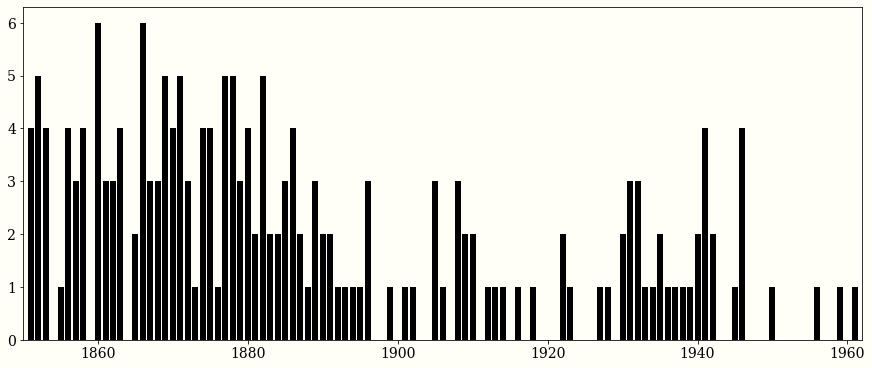

In [18]:
disasters_array = np.array(
    [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6, 3, 3, 5, 4, 5, 3, 
     1, 4, 4, 1, 5, 5, 3, 4, 2, 5, 2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 
     1, 3, 0, 0, 1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1, 0, 1, 
     0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2, 3, 3, 1, 1, 2, 1, 1, 1, 
     1, 2, 4, 2, 0, 0, 1, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 
     1])
years = np.arange(1851, 1962, dtype=int)

fig, ax = plt.subplots()
ax.vlines(years, 0, disasters_array, lw=6)
ax.set_xlim(years.min() - 1, years.max() + 1)
ax.set_ylim(bottom=0);

### Writing down the model and computing conditional distributions

It is perhaps easiest to write the model as a PyMC3 model. In notation, we might write

$$
y_t \sim \operatorname{Poisson}(\lambda_t), t=1851, \ldots, 1962 \\
\lambda_t = \left\{ \begin{array}{}\lambda_1 \text{ for } t \leq \tau \\ \lambda_2 \text{ for } t > \tau \end{array}\right. \\
\lambda_j \sim \operatorname{Gamma}(1, 10) \\
\tau \sim \operatorname{DiscreteUniform}(1851, 1962)
$$


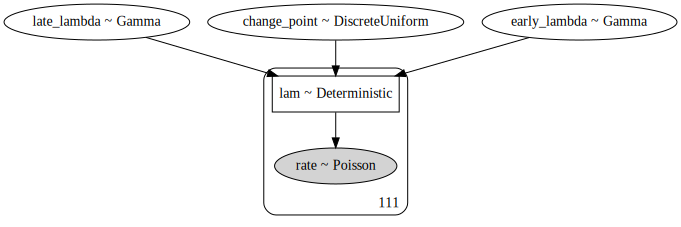

In [19]:
import pymc3 as pm


def coal_disaster_model():
    with pm.Model() as model:
        early_lambda = pm.Gamma('early_lambda', 1, 10)
        late_lambda = pm.Gamma('late_lambda', 1, 10)
        change_point = pm.DiscreteUniform('change_point', 1851, 1962)
        lam = pm.Deterministic('lam', pm.math.where(years > change_point, late_lambda, early_lambda))
        pm.Poisson('rate', lam, observed=disasters_array)
    return model

pm.model_to_graphviz(coal_disaster_model())

Now we need to go out and compute the conditional distributions:

$$
p(\tau | \lambda_1, \lambda_2, y_t) \\ 
p(\lambda_1 | \tau, \lambda_2, y_t) \\ 
p(\lambda_2 | \tau, \lambda_1, y_t)
$$

In this case, we can do some arithmetic, look up these distributions, and compute

$$
p(\tau | \lambda_1, \lambda_2, y_t) = \operatorname{Categorical}\left( \frac{\lambda_1^{\sum_{t=1851}^{\tau} y_t +\alpha-1} e^{-(\beta+\tau)\lambda_1} \lambda_2^{\sum_{t=\tau+1}^{1962} y_i + \alpha-1} e^{-\beta\lambda_2}}{\sum_{k=1851}^{1962} \lambda_1^{\sum_{t=1851}^{\tau} y_t +\alpha-1} e^{-(\beta+\tau)\lambda_1} \lambda_2^{\sum_{t=\tau+1}^{1962} y_i + \alpha-1} e^{-\beta\lambda_2}} \right) \\ 
p(\lambda_1 | \tau, \lambda_2, y_t) = \operatorname{Gamma}\left(\sum_{t=1851}^{\tau} y_t + \alpha, \tau + \beta\right)\\ 
p(\lambda_2 | \tau, \lambda_1, y_t) = \operatorname{Gamma}\left(\sum_{t=\tau + 1}^{1962} y_t + \alpha, 1962 - \tau + \beta\right)
$$

So far so good! Now here's an implementation!

In [20]:
def gibbs_sample_disaster(samples, tau=1900, early_lambda=6, late_lambda=2):
    """Can supply different initial conditions!"""
    draws = np.empty((3, samples))
    gamma_pdf = lambda lam, a, b: lam**(a-1) * np.exp(-b*lam)
    n_years = disasters_array.shape[0]
    years = np.arange(1851, 1962, dtype=int)
    draws = []
    while len(draws) < samples:
        # update early_lambda
        early_lambda = np.random.gamma(disasters_array[:tau - 1851].sum() + 1, 1 / (tau - 1851 + 10))
        draws.append([early_lambda, late_lambda, tau])
        
        # update late_lambda
        late_lambda = np.random.gamma(disasters_array[tau - 1851 + 1:].sum() + 1, 1 / (1962 - tau + 10))
        draws.append([early_lambda, late_lambda, tau])
        
        # update tau
        tau_probs = np.empty(n_years)
        for t in range(n_years):
            tau_probs[t] = (gamma_pdf(early_lambda, disasters_array[:t].sum() + 1, t + 10) *
                            gamma_pdf(late_lambda, disasters_array[t:].sum() + 1, n_years - t + 10))
        tau = np.random.choice(years, p=tau_probs / tau_probs.sum())
        draws.append([early_lambda, late_lambda, tau])
    return np.array(draws)[:samples]


### Checking our work

We compare the Gibbs sampler to the PyMC3 model -- this one goes a bit faster, but maybe it took me longer to write!

In [21]:
%%time
draws = gibbs_sample_disaster(1000)
draws.mean(axis=0) # early_lambda, late_lambda, change_point

CPU times: user 1.16 s, sys: 8 ms, total: 1.16 s
Wall time: 1.16 s


array([2.47437904e+00, 8.03613825e-01, 1.89312600e+03])

In [22]:
%%time
with coal_disaster_model():
    trace = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [late_lambda, early_lambda]
>Metropolis: [change_point]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1727.51draws/s]
The acceptance probability does not match the target. It is 0.8872391012695667, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


CPU times: user 7.25 s, sys: 428 ms, total: 7.68 s
Wall time: 9.43 s


In [23]:
pm.summary(trace, varnames=['early_lambda', 'late_lambda', 'change_point', ])

/home/colin/miniconda3/envs/bayes_course/lib/python3.7/site-packages/pymc3/stats/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
early_lambda,2.483,0.236,2.051,2.921,0.007,0.005,1016.0,1016.0,991.0,972.0,1.00
late_lambda,0.813,0.102,0.622,0.998,0.002,0.002,1747.0,1747.0,1721.0,1418.0,1.00
change_point,1891.782,2.544,1887.000,1896.000,0.226,0.160,127.0,127.0,139.0,215.0,1.04



### More contrived example

This example shows how you might use some knowledge of conjugate distributions to start to automate a Gibbs sampler.

Suppose we have a generative model:

$$
w_1 \sim \mathcal{N}(0, 1) \\
w_2 \sim \mathcal{N}(0, 1) \\
x \sim \mathcal{N}(w_1 + w_2, 1)
$$

Then we observe $x$, and wish to compute $p(w_1, w_2 | x)$.

We will do this by inializing at some point $(w_1^0, w_2^0)$, then 
1. drawing $w_1^1 \sim p(w_1 | w_2^0, x)$, 
2. drawing $w_2^1 \sim p(w_2 | w_1^1, x)$

We now have samples $\{ (w_1^0, w_2^0),(w_1^1, w_2^0),(w_1^1, w_2^1) \}$, and we go back and sample $w_1^2$.

We are going to use the following fact:

If $x \sim \mathcal{N}(\mu, \sigma)$ and $y \sim \mathcal{N}(x, s)$, then 

$$
x | y \sim \mathcal{N}\left(\frac{1}{\sigma + s} (\sigma y + s \mu), \frac{1}{\sigma + s}\right),
$$

which collapses to 

$$
x | y \sim \mathcal{N}\left(\frac{y}{2}, \frac{1}{2}\right),
$$

when $\sigma = s = 1$ and $\mu = 0$. We can use this to make our update rule below.

In [24]:
def gibbs_sample(draws, init, observed):
    current = init.copy()
    samples = np.empty((draws, 2))
    for idx in range(draws):
        residual = observed - current[(idx + 1) % 2]
        current[idx % 2] = 0.5 * (np.random.randn() + residual)
        samples[idx] = current.copy()
    return samples

In [25]:
%time samples = gibbs_sample(2_000, np.zeros(2), 1) # fast!

CPU times: user 20 ms, sys: 8 ms, total: 28 ms
Wall time: 21.7 ms


### Demonstrating that the Gibbs sampler works, and maybe an easier way to do it

We can just implement the same model with PyMC3. It does not always compare so favorably, but this is pretty nice.

In [26]:
%%time

with pm.Model():
    w_1 = pm.Normal('w_1')
    w_2 = pm.Normal('w_2')
    x = pm.Normal('x', w_1 + w_2, 1, observed=1)
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_2, w_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2233.56draws/s]


CPU times: user 2.94 s, sys: 196 ms, total: 3.13 s
Wall time: 3.96 s


[0.32080529 0.37027169] [0.30039211772347, 0.33517966826246315]


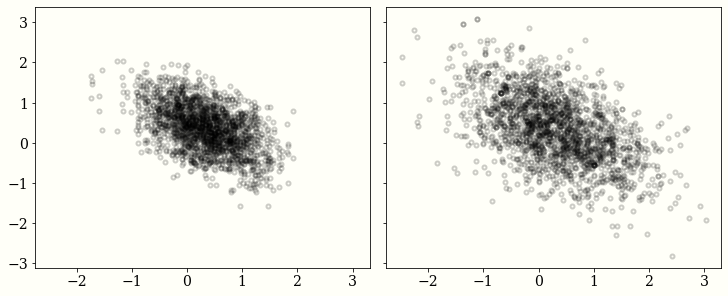

In [27]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharex=True, sharey=True)
axes[0].plot(*samples.T, '.', alpha=0.2)
axes[1].plot(trace['w_1'], trace['w_2'], '.', alpha=0.2);
print(samples.mean(axis=0), [trace['w_1'].mean(), trace['w_2'].mean()])

### Gibbs Sampling Exercise

1. Adjust the Gibbs sampler so that the likelihood $x \sim \mathcal{N}(w_1 + w_2, 10)$ (that is, $s$ in our derivation is now 10).
2. Also adjust the PyMC3 program so the likelihood is now 10.
3. Remake the plot above.

## Hamiltonian Monte Carlo

1. We concatenate all of our parameters into a single _position_ variable, $\mathbf{q}$. We are trying to sample from the probability density function $\pi(\mathbf{q})$. 

2. We add a _momentum_ variable, $\mathbf{p}$, of the same dimension as $\mathbf{q}$, and consider the probability distribution 
$$
\pi(\mathbf{q}, \mathbf{p}) =  \pi(\mathbf{p} | \mathbf{q}) \pi(\mathbf{q}),
$$
where we get to choose $\pi(\mathbf{p} | \mathbf{q})$. In practice, we will choose $\pi(\mathbf{p} | \mathbf{q}) = \mathcal{N}(\mathbf{0}, M)$, and in this essay, we will choose $M = I$.
3. Define the _Hamiltonian_, $H(\mathbf{q}, \mathbf{p}) = -\log \pi(\mathbf{q}, \mathbf{p})$.Given the factorization above, we get
$$
H(\mathbf{q}, \mathbf{p}) = -\log \pi(\mathbf{p} | \mathbf{q}) - \log \pi(\mathbf{q}) = K(\mathbf{p}, \mathbf{q}) + V(\mathbf{q}),
$$
where $K(\mathbf{p}, \mathbf{q})$ is called the _kinetic energy_, and $V(\mathbf{q})$ is called the _potential energy_, using an analogy to physical systems.
4. We evolve the system $(\mathbf{q}, \mathbf{p})$ according to _Hamilton's equations_:
$$
\frac{d \mathbf{q}}{dt} = \frac{\partial H}{\partial \mathbf{p}} = \frac{\partial K}{\partial \mathbf{p}} + \frac{\partial V}{\partial \mathbf{p}}\\
\frac{d \mathbf{p}}{dt} = -\frac{\partial H}{\partial \mathbf{q}}= -\frac{\partial K}{\partial \mathbf{q}} + \frac{\partial V}{\partial \mathbf{q}}
$$
Note that $\frac{\partial V}{\partial \mathbf{p}} = \mathbf{0}$.

We chose the kinetic energy to be a Gaussian, which lets us calculate those gradients by hand instead of recalculating them. Specifically, 
$$
K(\mathbf{p}, \mathbf{q}) = \frac{1}{2}\mathbf{p}^T M^{-1}\mathbf{p} + \log |M| + \text{const.},
$$
and with our choice of $M = I$, 
$$
K(\mathbf{p}, \mathbf{q}) = \frac{1}{2}\mathbf{p}^T \mathbf{p} + \text{const.},
$$
so 
$$
\frac{\partial K}{\partial \mathbf{p}} = \mathbf{p}
$$
and
$$
\frac{\partial K}{\partial \mathbf{q}} = \mathbf{0}
$$

We can then simplify Hamilton's equations to:

$$
\frac{d \mathbf{q}}{dt}  = \mathbf{p} \\
\frac{d \mathbf{p}}{dt} = - \frac{\partial V}{\partial \mathbf{q}}
$$

This is the algorithm, then:
- Sample a $\mathbf{p} \sim \mathcal{N}(0, I)$,
- Simulate $\mathbf{q}(t)$ and $\mathbf{p}(t)$ for some amount of time $T$ using the simplified equations above
- $\mathbf{q}(T)$ is our new sample. 

### Pictures are easier. 

Here are three Hamiltonian trajectories

<video controls width=800 src="images/hmc_examples.mp4" />


Here is a 1d distribution, and how HMC samples from it. Notice that the trajectories are in momentum-position space.

<img src="images/integrator_pdf.png">

<video controls width=800 src="images/animated_sample.mp4" />


Step size effects how fast HMC goes. Each gradient evaluation is quite expensive! These animations have the same frame rate.


<video controls width=800 src="images/multi_animated_sample.mp4" />

When integration goes wrong, it goes very wrong. This is a "funnel", a well known example. Similar shapes appear in hierarchical models.

<img src="images/funnel_leapfrog.png">